<a href="https://colab.research.google.com/github/Phiziics/Project-14--Natural-Language-Processing/blob/main/Project_14_ML_for_Texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [ ]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [ ]:
""" %matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')"""

" %matplotlib inline\n%config InlineBackend.figure_format = 'png'\n# the next line provides graphs of better quality on HiDPI screens\n%config InlineBackend.figure_format = 'retina'\n\nplt.style.use('seaborn')"

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use seaborn to set the style
sns.set_theme(style='whitegrid')

# for high-DPI images for HiDPI screens
%config InlineBackend.figure_format = 'retina'

In [ ]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [ ]:
import csv

df_reviews = pd.read_csv('/content/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'}, quoting=csv.QUOTE_NONE)

In [ ]:
df_reviews.duplicated().sum()

0

In [ ]:
df_reviews.isnull().sum()

,0
tconst,0
title_type,0
primary_title,0
original_title,0
start_year,0
end_year,0
runtime_minutes,0
is_adult,0
genres,0
average_rating,0


In [ ]:
# fill missing values

df_reviews['average_rating'].fillna(df_reviews['average_rating'].median(), inplace=True)
df_reviews['votes'].fillna(df_reviews['votes'].median(), inplace=True)

In [ ]:
df_reviews.isnull().sum()

,0
tconst,0
title_type,0
primary_title,0
original_title,0
start_year,0
end_year,0
runtime_minutes,0
is_adult,0
genres,0
average_rating,0


## EDA

Let's check the number of movies and reviews over years.

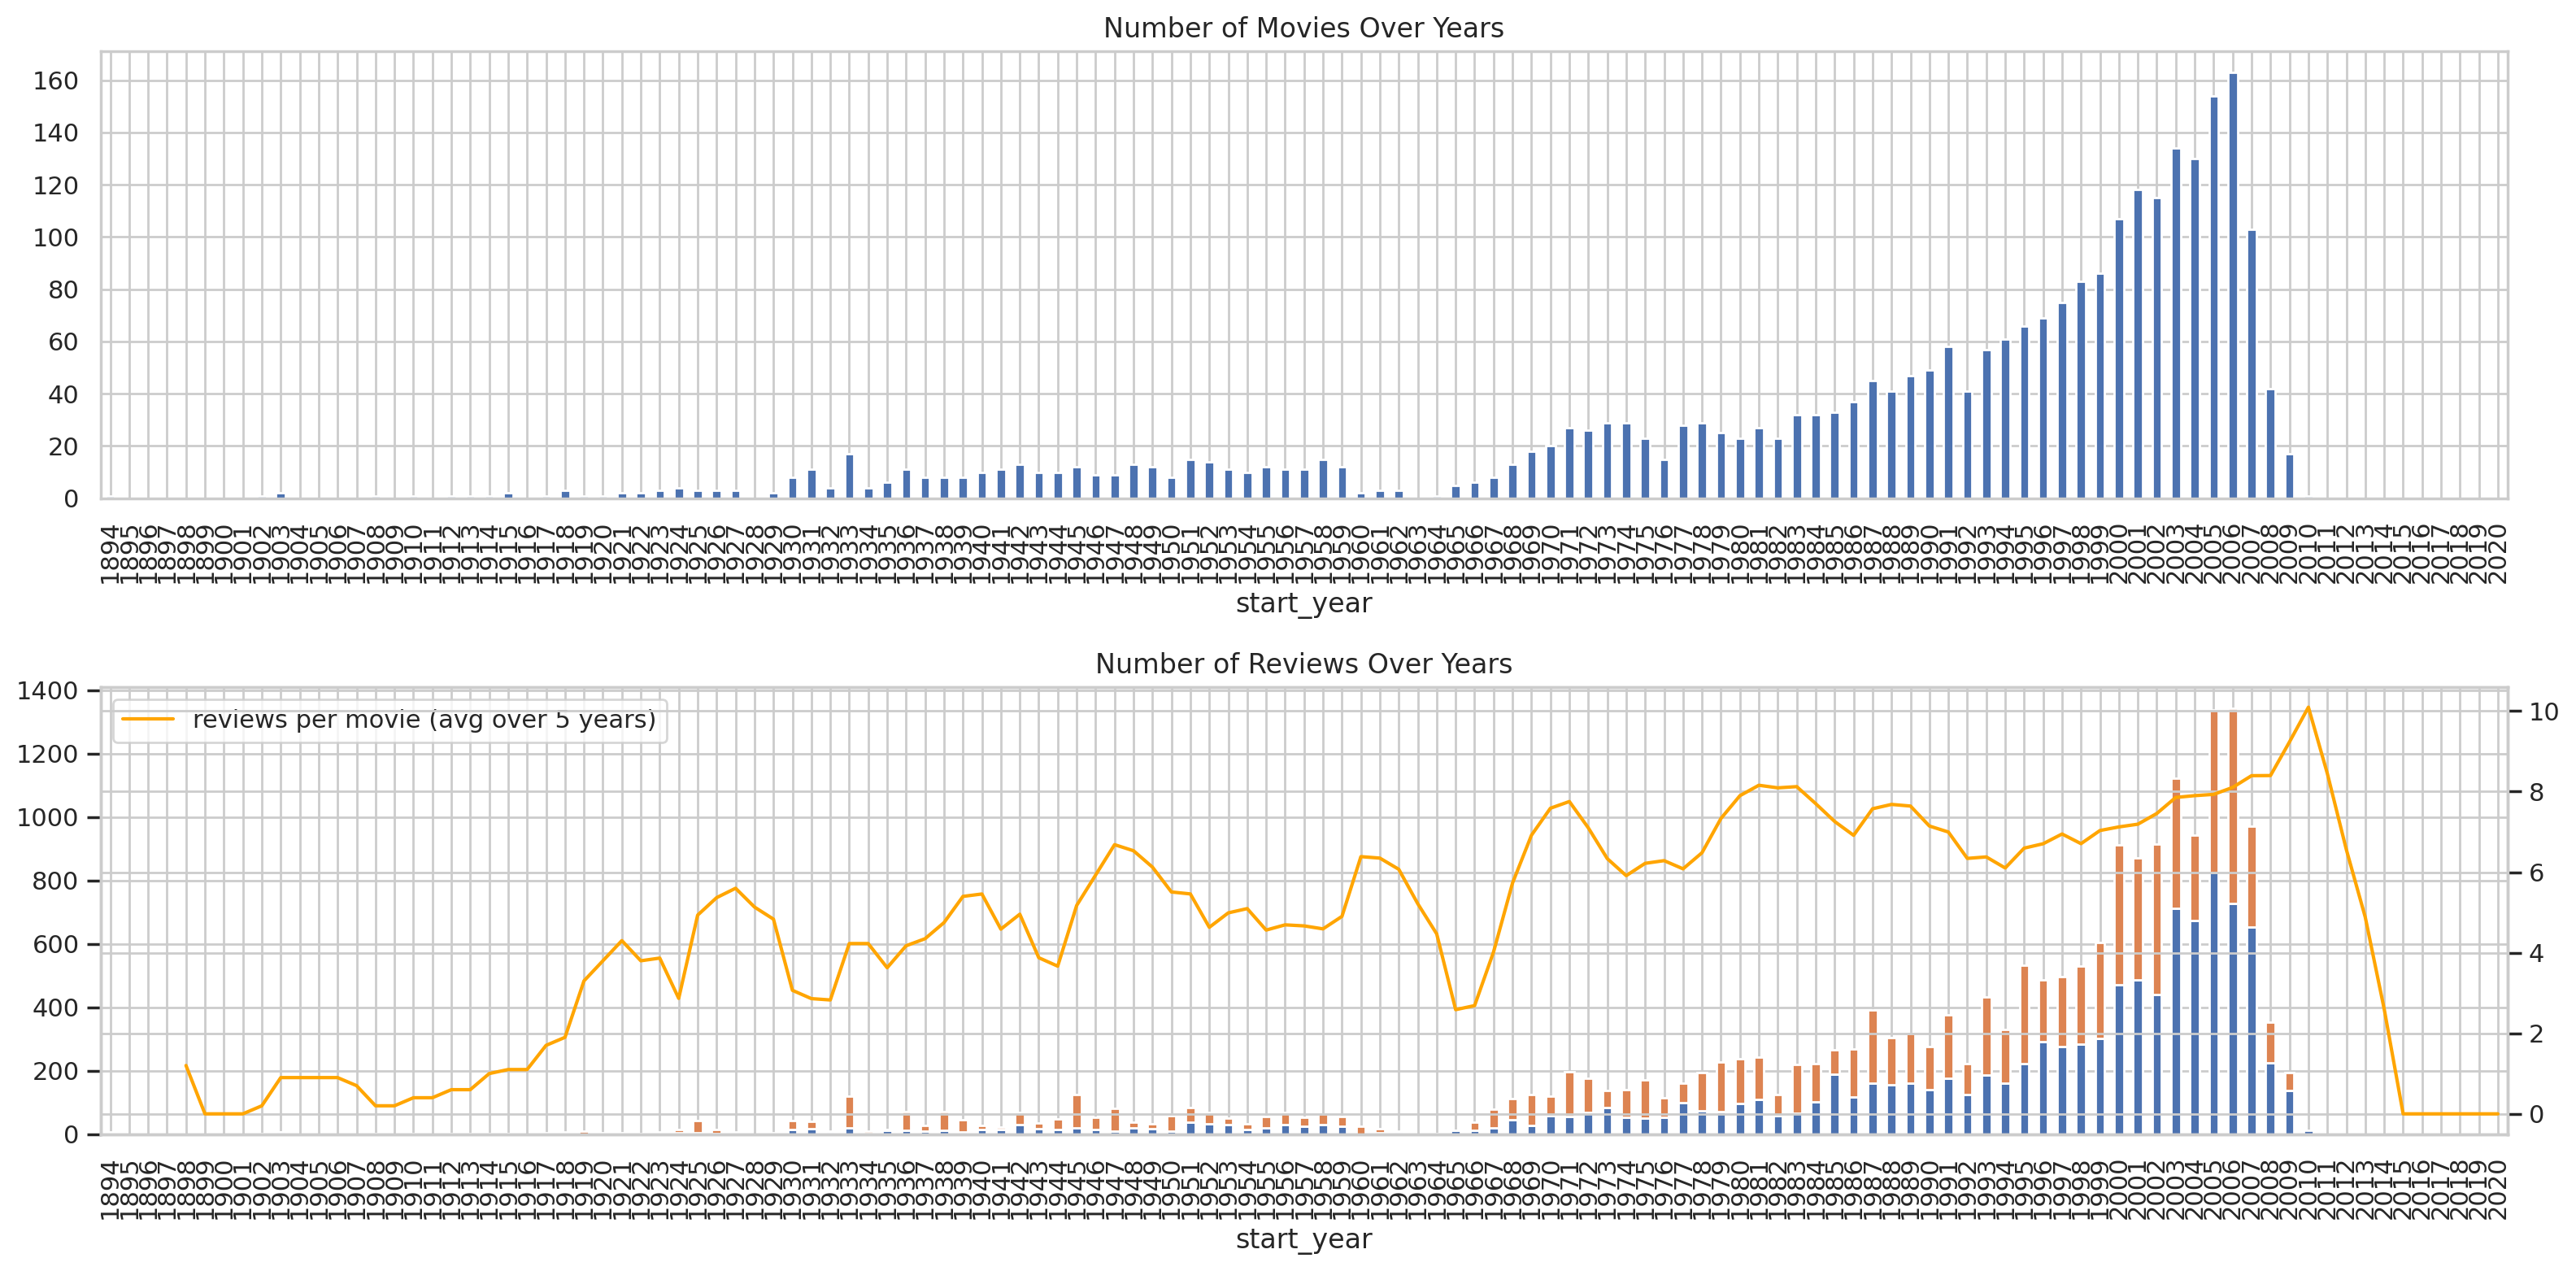

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The film industry has grown substantially over the past century, with significant acceleration in recent decades.
The number of reviews per movie has generally increased over time, suggesting growing public engagement with cinema or more platforms for reviewing.
Both graphs show a sharp decline in 2006, likely due to the impact of the global recession or some other factor.
The digital age (post-2000) seems to have had a major impact on both movie production and review volumes, possibly due to easier access to filmmaking technology and online review platforms.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

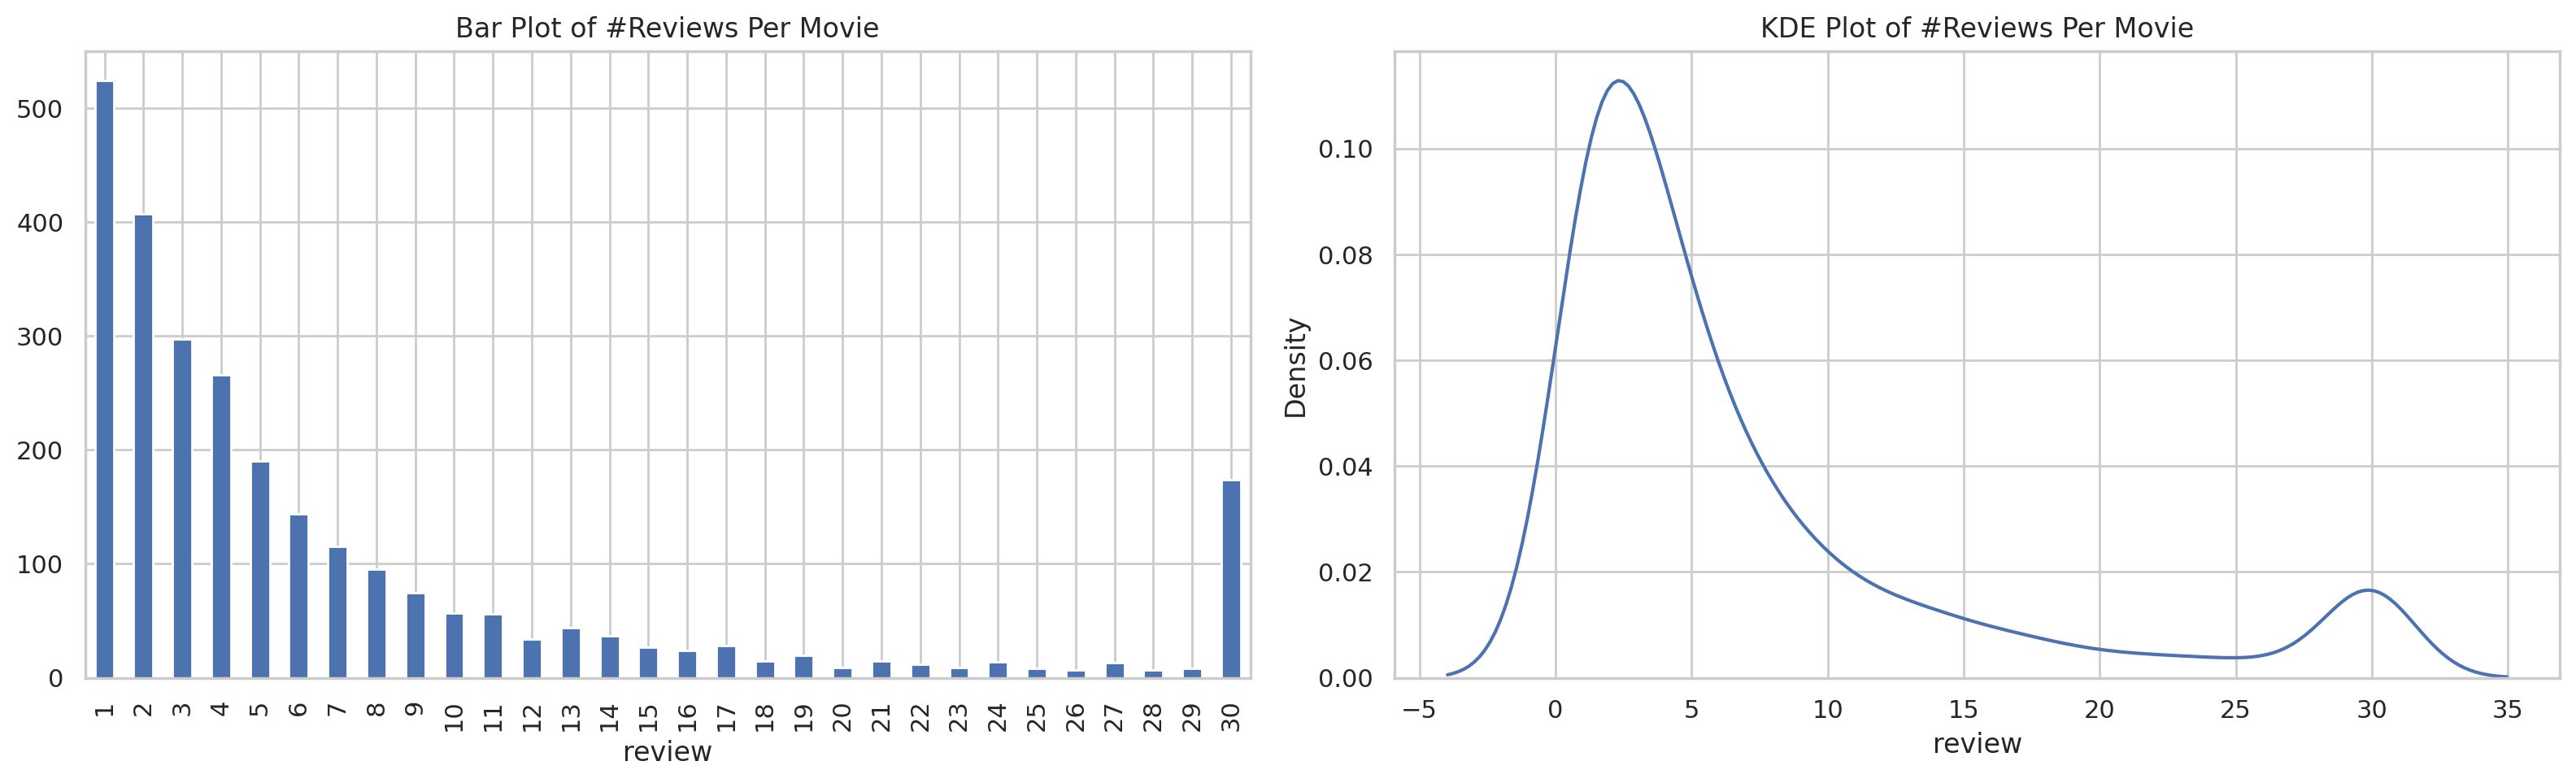

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The distribution is highly skewed, with most movies receiving very few reviews (1-3).
There's a long tail in the distribution, with a small number of movies receiving many reviews.
The secondary peak in the KDE plot suggests there might be two distinct groups of movies: those that receive minimal attention (few reviews) and those that gain significant popularity (many reviews).
The bar plot and KDE plot complement each other, with the bar plot providing a clear count and the KDE offering a smoother representation of the distribution.

This distribution suggests that while most movies struggle to get reviews, a select few generate significant engagement. This could reflect factors like marketing budgets, critical acclaim, or viral popularity affecting review counts.

In [ ]:
df_reviews['pos'].value_counts()

,count
pos,
0.0,10123
1.0,9505


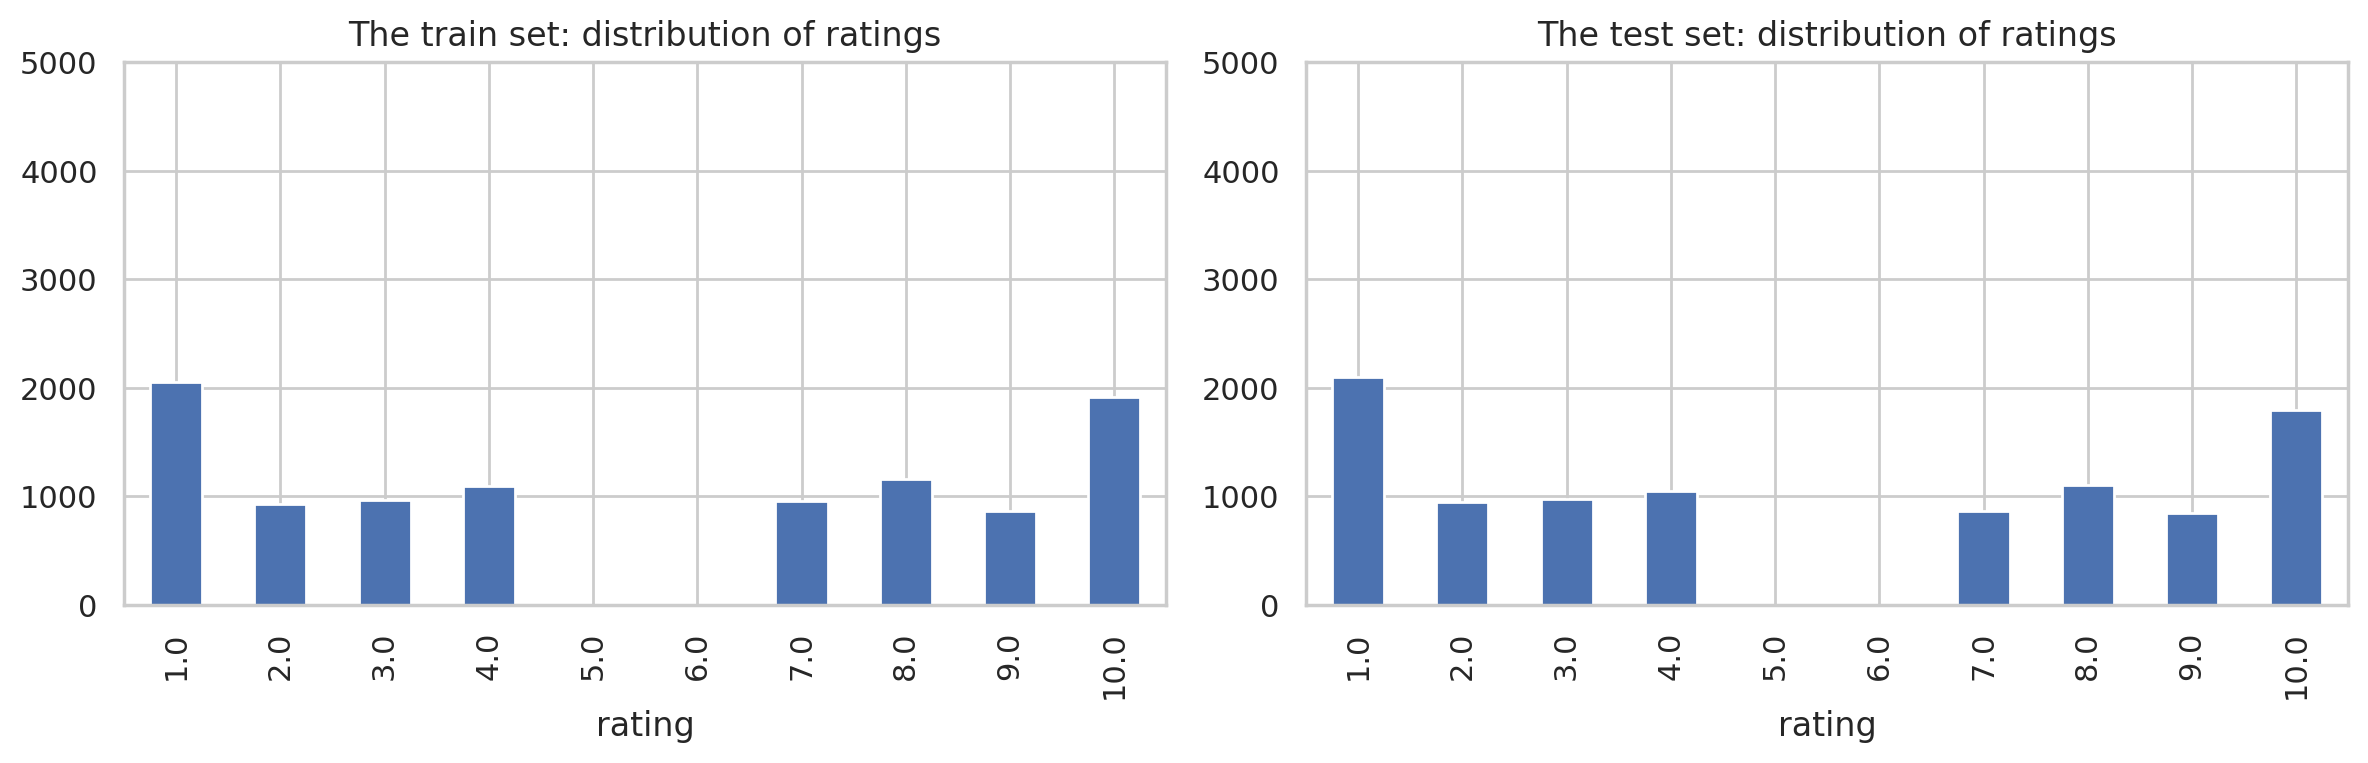

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Both sets show a strong U-shaped distribution, indicating that extreme ratings (1 and 10) are much more common than middle ratings.
The similarity between train and test set distributions suggests good data splitting, maintaining the overall distribution in both sets.
The absence of data for ratings 5 and 6 is notable and could indicate:

- A rating system that doesn't use these middle values
- Data preprocessing that has grouped ratings into broader categories
- A tendency for raters to avoid neutral ratings

There's a slight preference for positive ratings (7-10) over negative ratings (2-4) in both sets.
The high frequency of 1-star ratings might indicate a significant number of very dissatisfied users or possibly spam/bot ratings.

This distribution suggests that users tend to give extreme ratings more often than moderate ones, which is a common phenomenon in rating systems. The consistency between train and test sets is crucial for developing a reliable predictive model.

Distribution of negative and positive reviews over the years for two parts of the dataset

<ipython-input-14-e0e81b3a9b29>:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-14-e0e81b3a9b29>:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
<ipython-input-14-e0e81b3a9b29>:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-14-e0e81b3a9b29>:31: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

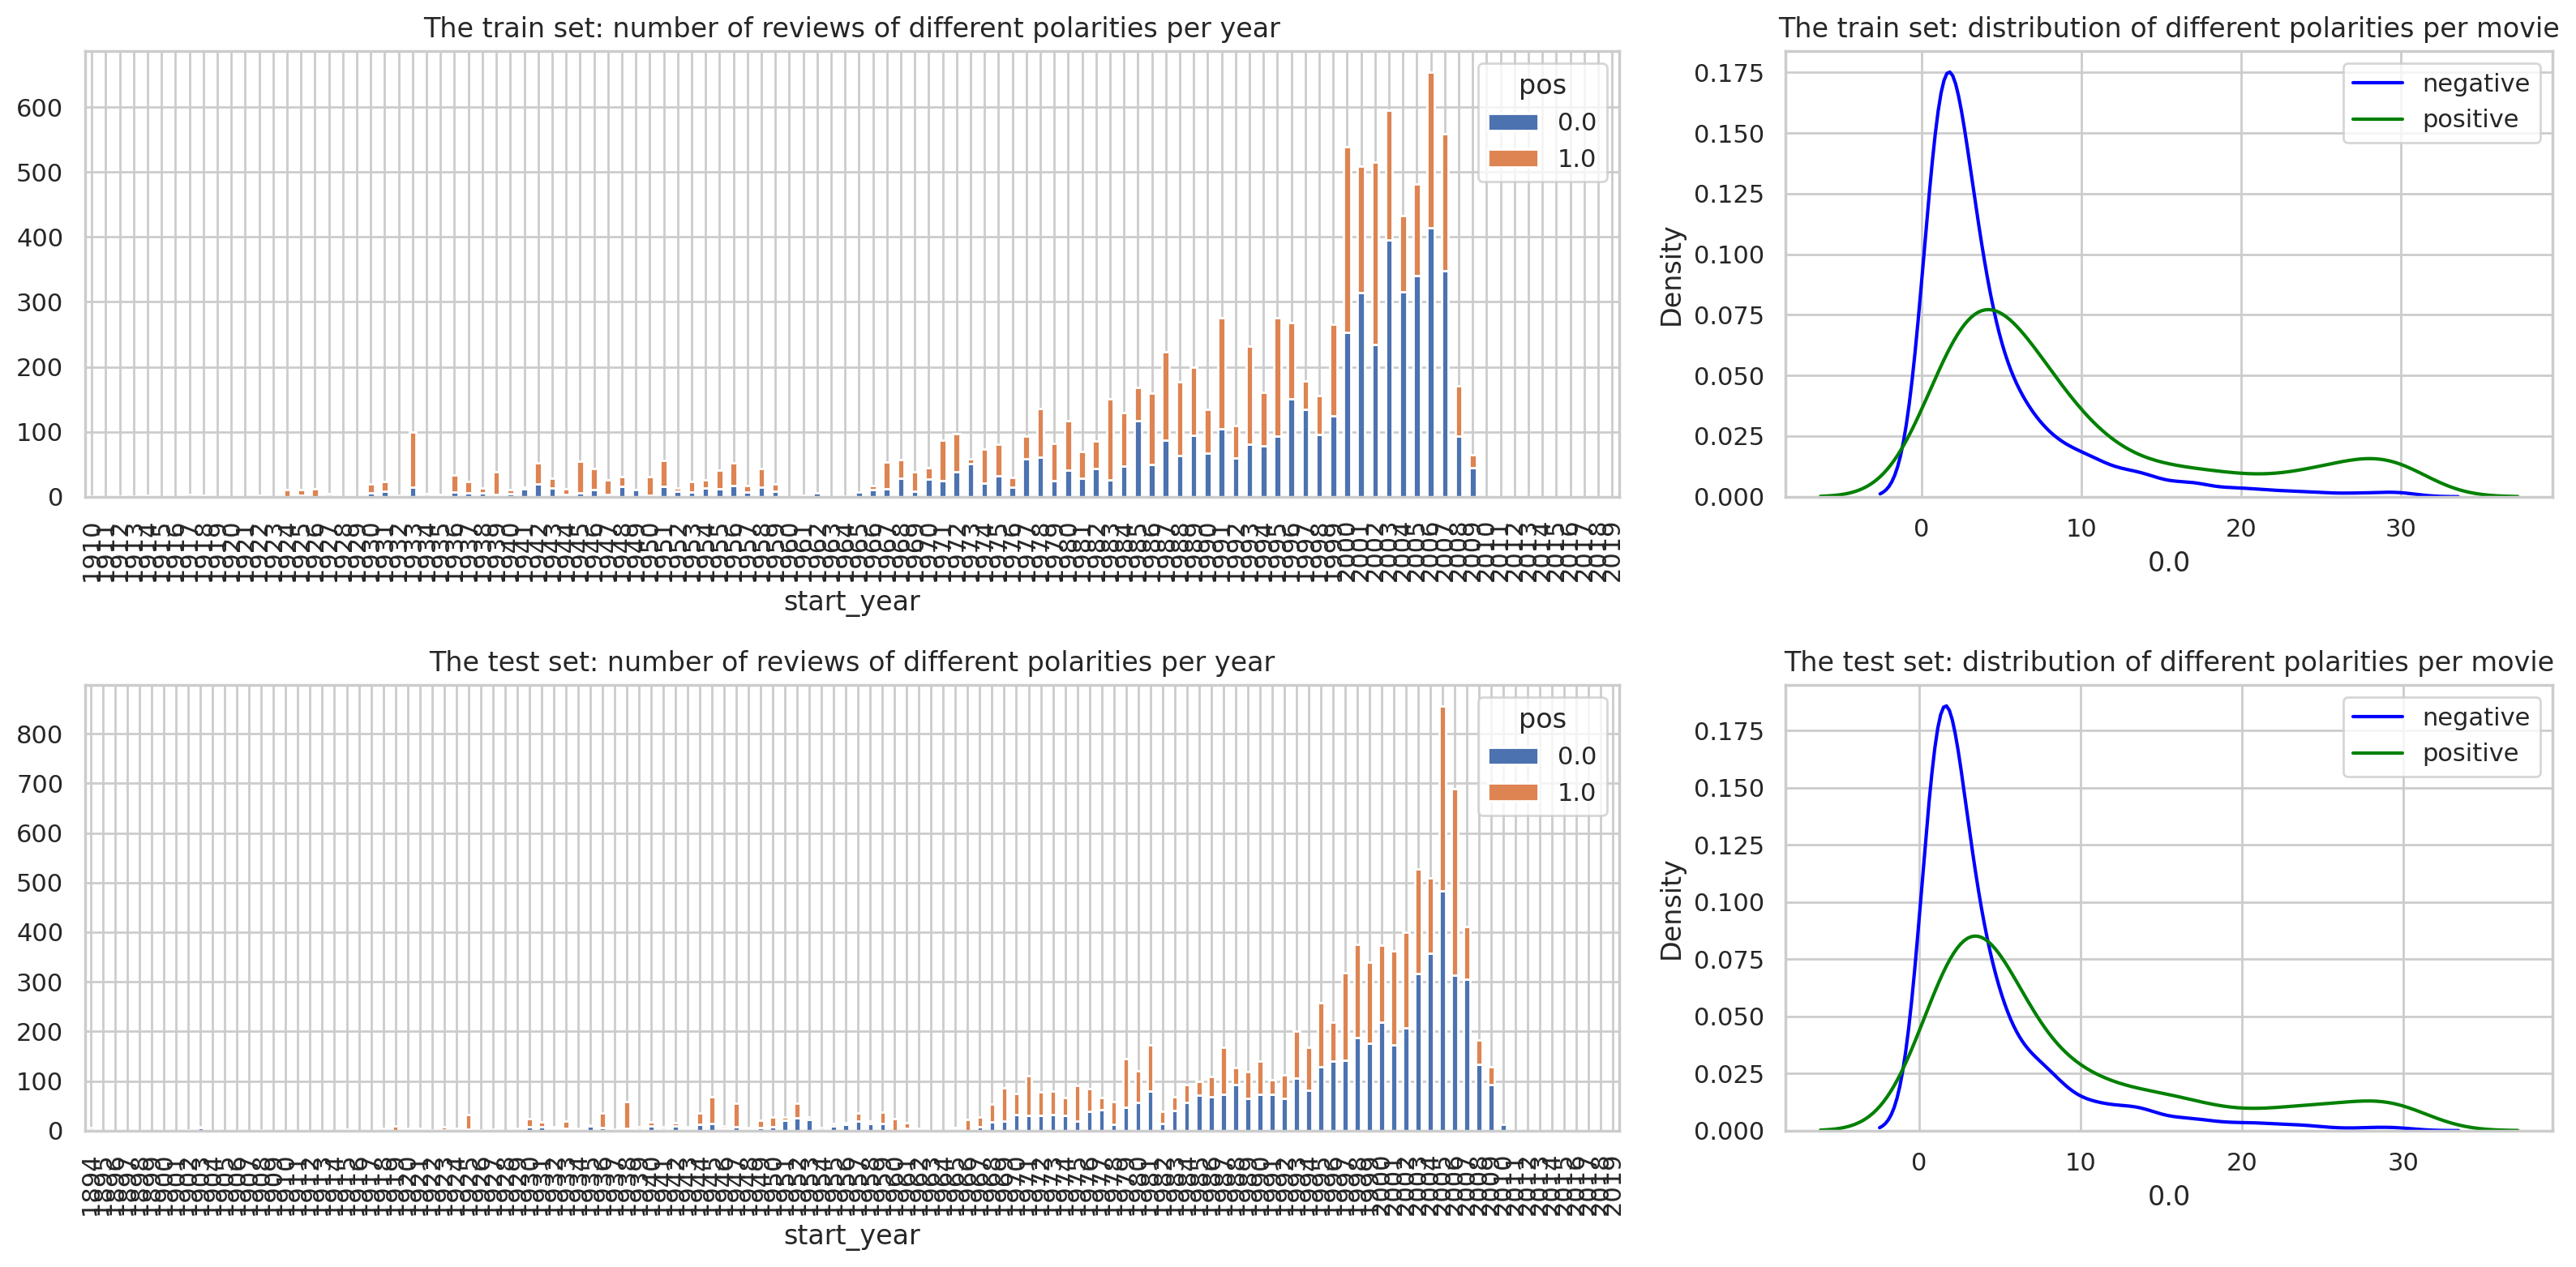

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Consistency between train and test sets suggests good data splitting, which is crucial for model development and evaluation.
There's a clear trend of increasing review numbers over time, possibly reflecting the growth of online review platforms or increased movie production.
Positive reviews consistently outnumber negative reviews across the years, indicating a general positive bias in movie reviews.
The distribution of reviews per movie shows that most movies receive few reviews, especially negative ones, while a small number of movies receive many reviews.
The recent decline in review numbers could be due to data collection cut-off or a real-world event (e.g., pandemic affecting movie releases).
The similarity in distributions between positive and negative reviews suggests that the sentiment analysis task is well-balanced, which is important for training an unbiased model.

This data structure provides a solid foundation for training and testing a sentiment analysis model for movie reviews, with good representation of both positive and negative sentiments across different time periods and movies.

In [ ]:
category = df_reviews['pos'].value_counts()

Text(0.5, 1.0, 'Class Distribution')

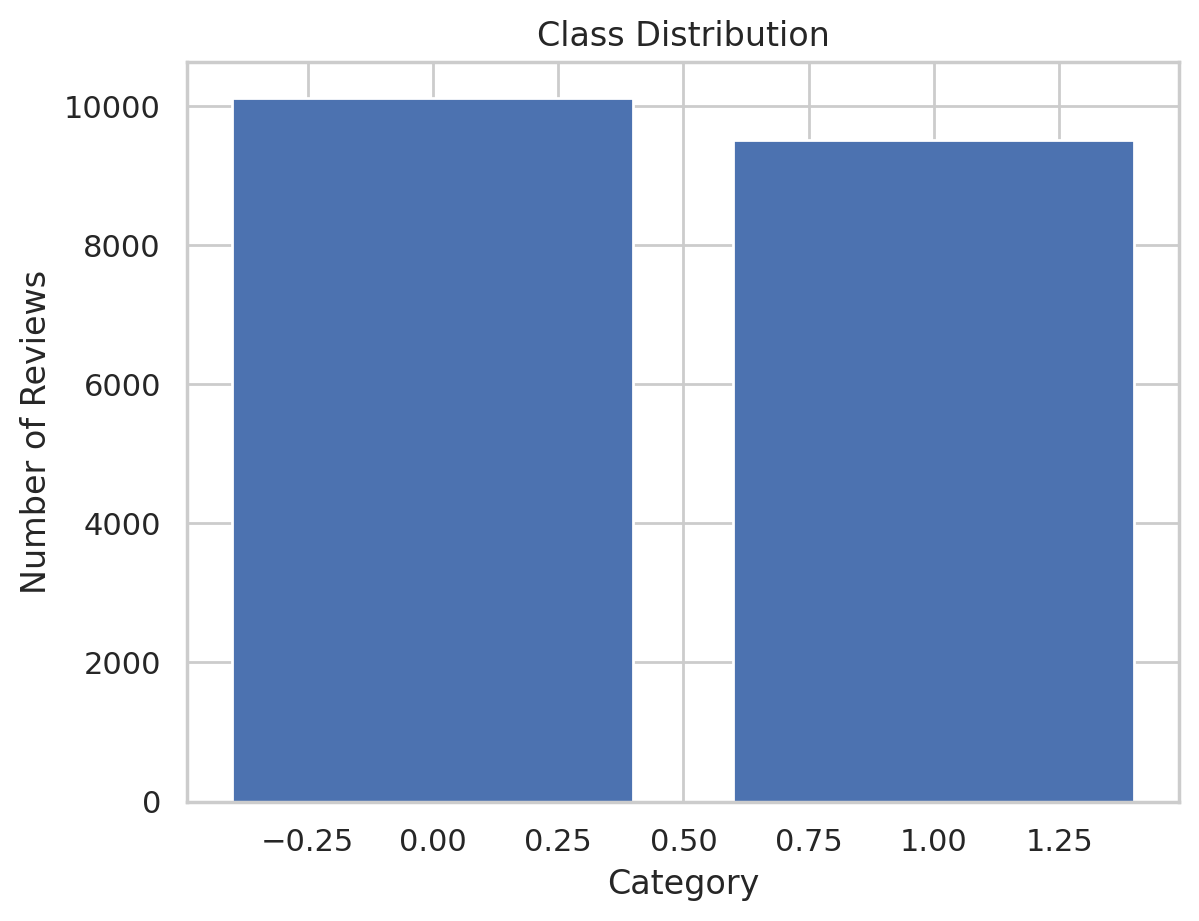

In [ ]:
plt.bar(category.index, category.values)
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.title('Class Distribution')

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [ ]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [ ]:
import re

In [ ]:
def normalize_text(text):
    text = text.lower() # lowercase of the text
    text = re.sub(r'\d+', '', text) # remove digits
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation mark
    text = re.sub(r'\s+', ' ', text) # remove extra white space
    return text

In [ ]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(9944, 18)
(9684, 18)


In [ ]:
import sys
import gc

# Check memory usage of df_reviews
print(f"Memory usage of df_reviews: {sys.getsizeof(df_reviews)} bytes")

Memory usage of df_reviews: 67864459 bytes


In [ ]:
# Delete df_reviews to free up memory
del df_reviews

# Force garbage collection to free up memory
gc.collect()

10502

In [ ]:
# Drop the target column ('pos') and the review column ('review') from the training and test sets to get features
df_reviews_train = df_reviews_train.drop(columns=['pos', 'review'])
df_reviews_test = df_reviews_test.drop(columns=['pos', 'review'])

## Working with models

### Model 0 - Constant

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
# initiate the dummy classifier
model_0 = DummyClassifier(strategy='constant', constant=1)

In [ ]:
# train the model
model_0.fit(df_reviews_train, target_train)

DummyClassifier(constant=1, strategy='constant')

In [ ]:
# predict on the training on the test dataset
train_predict = model_0.predict(df_reviews_train)
test_predict = model_0.predict(df_reviews_test)

          train  test
Accuracy   0.49  0.48
F1         0.66  0.64
APS        0.49  0.48
ROC AUC    0.50  0.50


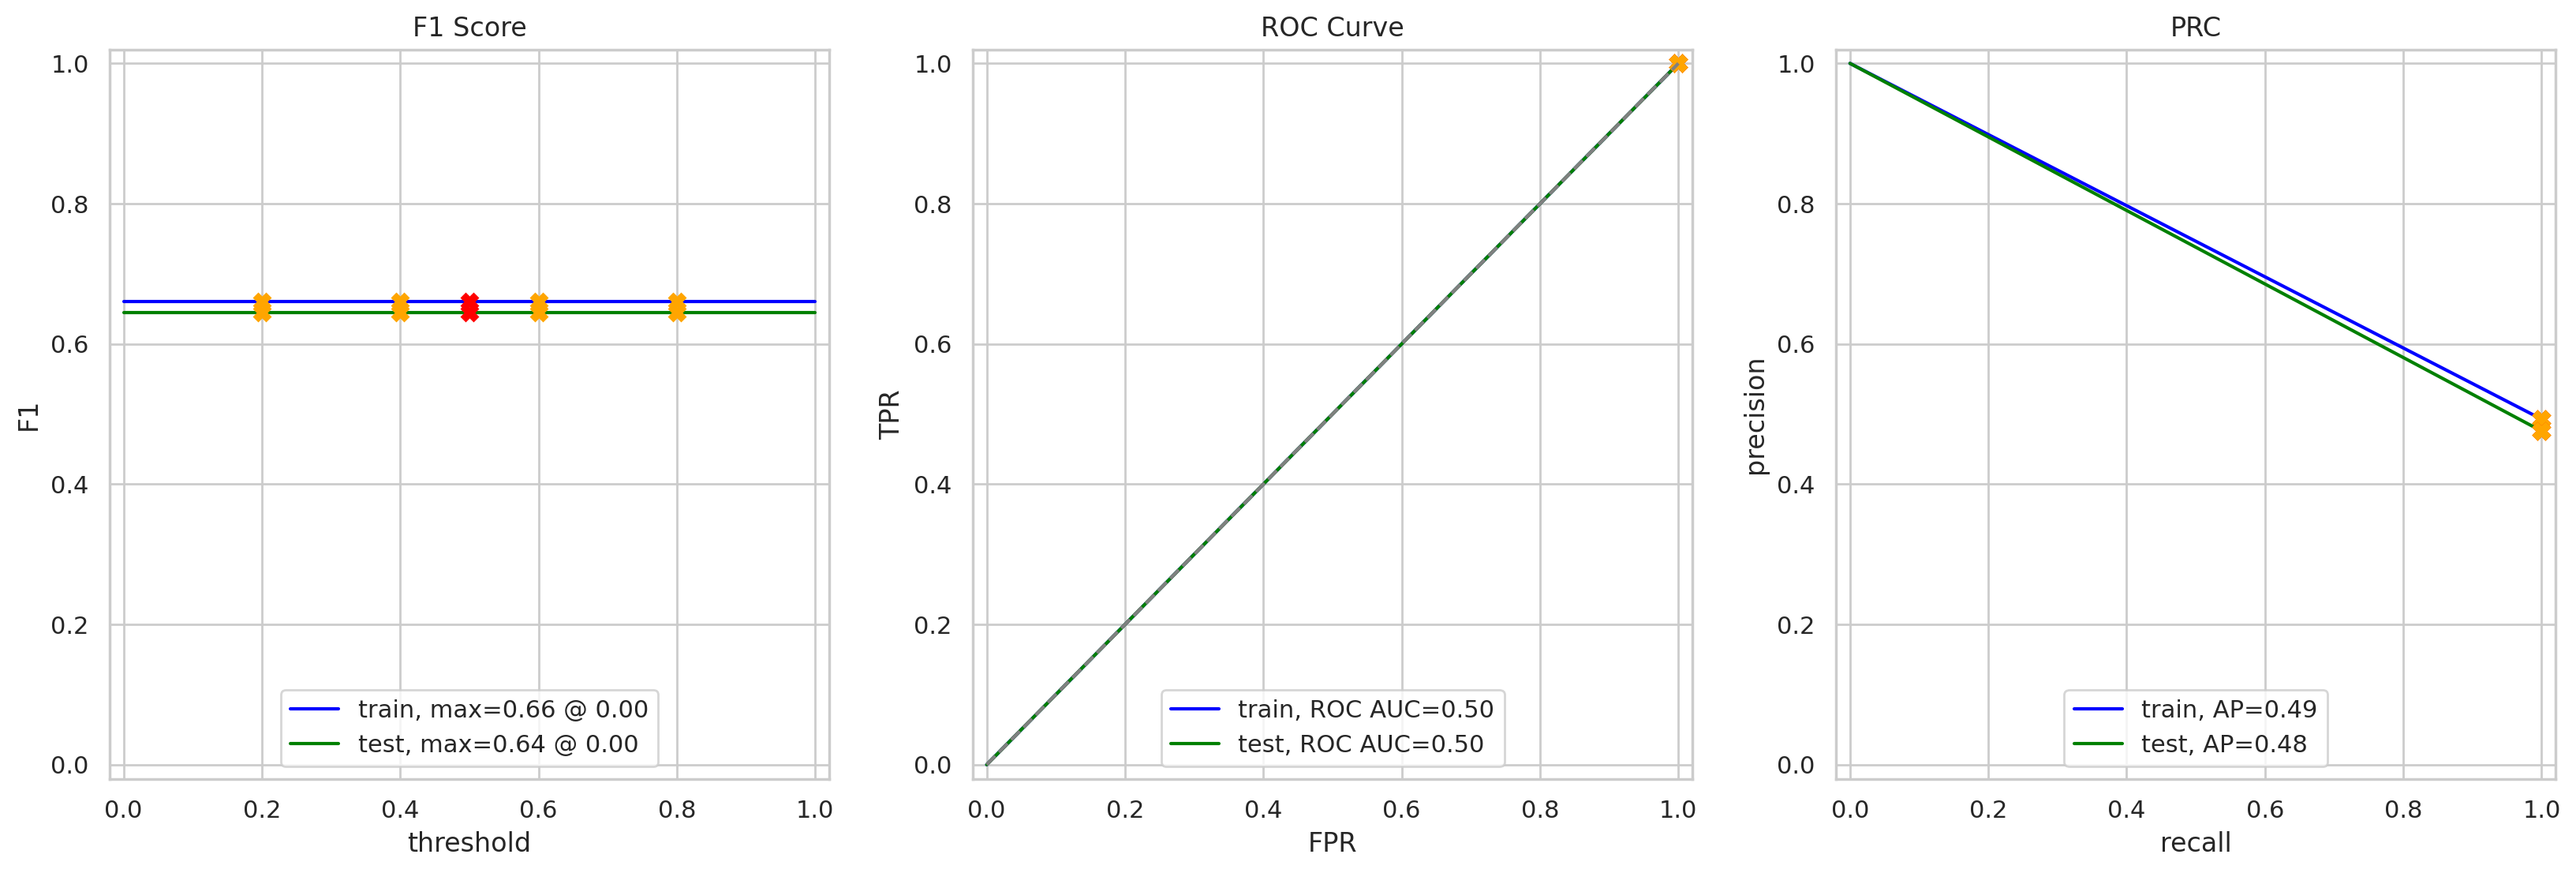

In [ ]:
evaluate_model(model_0, df_reviews_train, target_train, df_reviews_test, target_test)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [ ]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [ ]:
# download nltk words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# define stop words
stop_words = stopwords.words('english')

In [ ]:
# create TF-IDF Vectorizer
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words, lowercase=True, use_idf=True, ngram_range=(1,2))

In [ ]:
# transform the normalized review text to tfidf vectors
features_train_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
features_test_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

In [ ]:
features_train_1.shape

(9944, 864165)

In [ ]:
features_test_1.shape

(9684, 864165)

In [ ]:
# initaite logistic regression
model_1 = LogisticRegression(max_iter=1000)

In [ ]:
# Train the model
model_1.fit(features_train_1, target_train)

LogisticRegression(max_iter=1000)

In [ ]:
# predic the training and test datasets
train_predict_1 = model_1.predict(features_train_1)
test_predict_1 = model_1.predict(features_test_1)

          train  test
Accuracy   0.98  0.86
F1         0.98  0.86
APS        1.00  0.93
ROC AUC    1.00  0.94


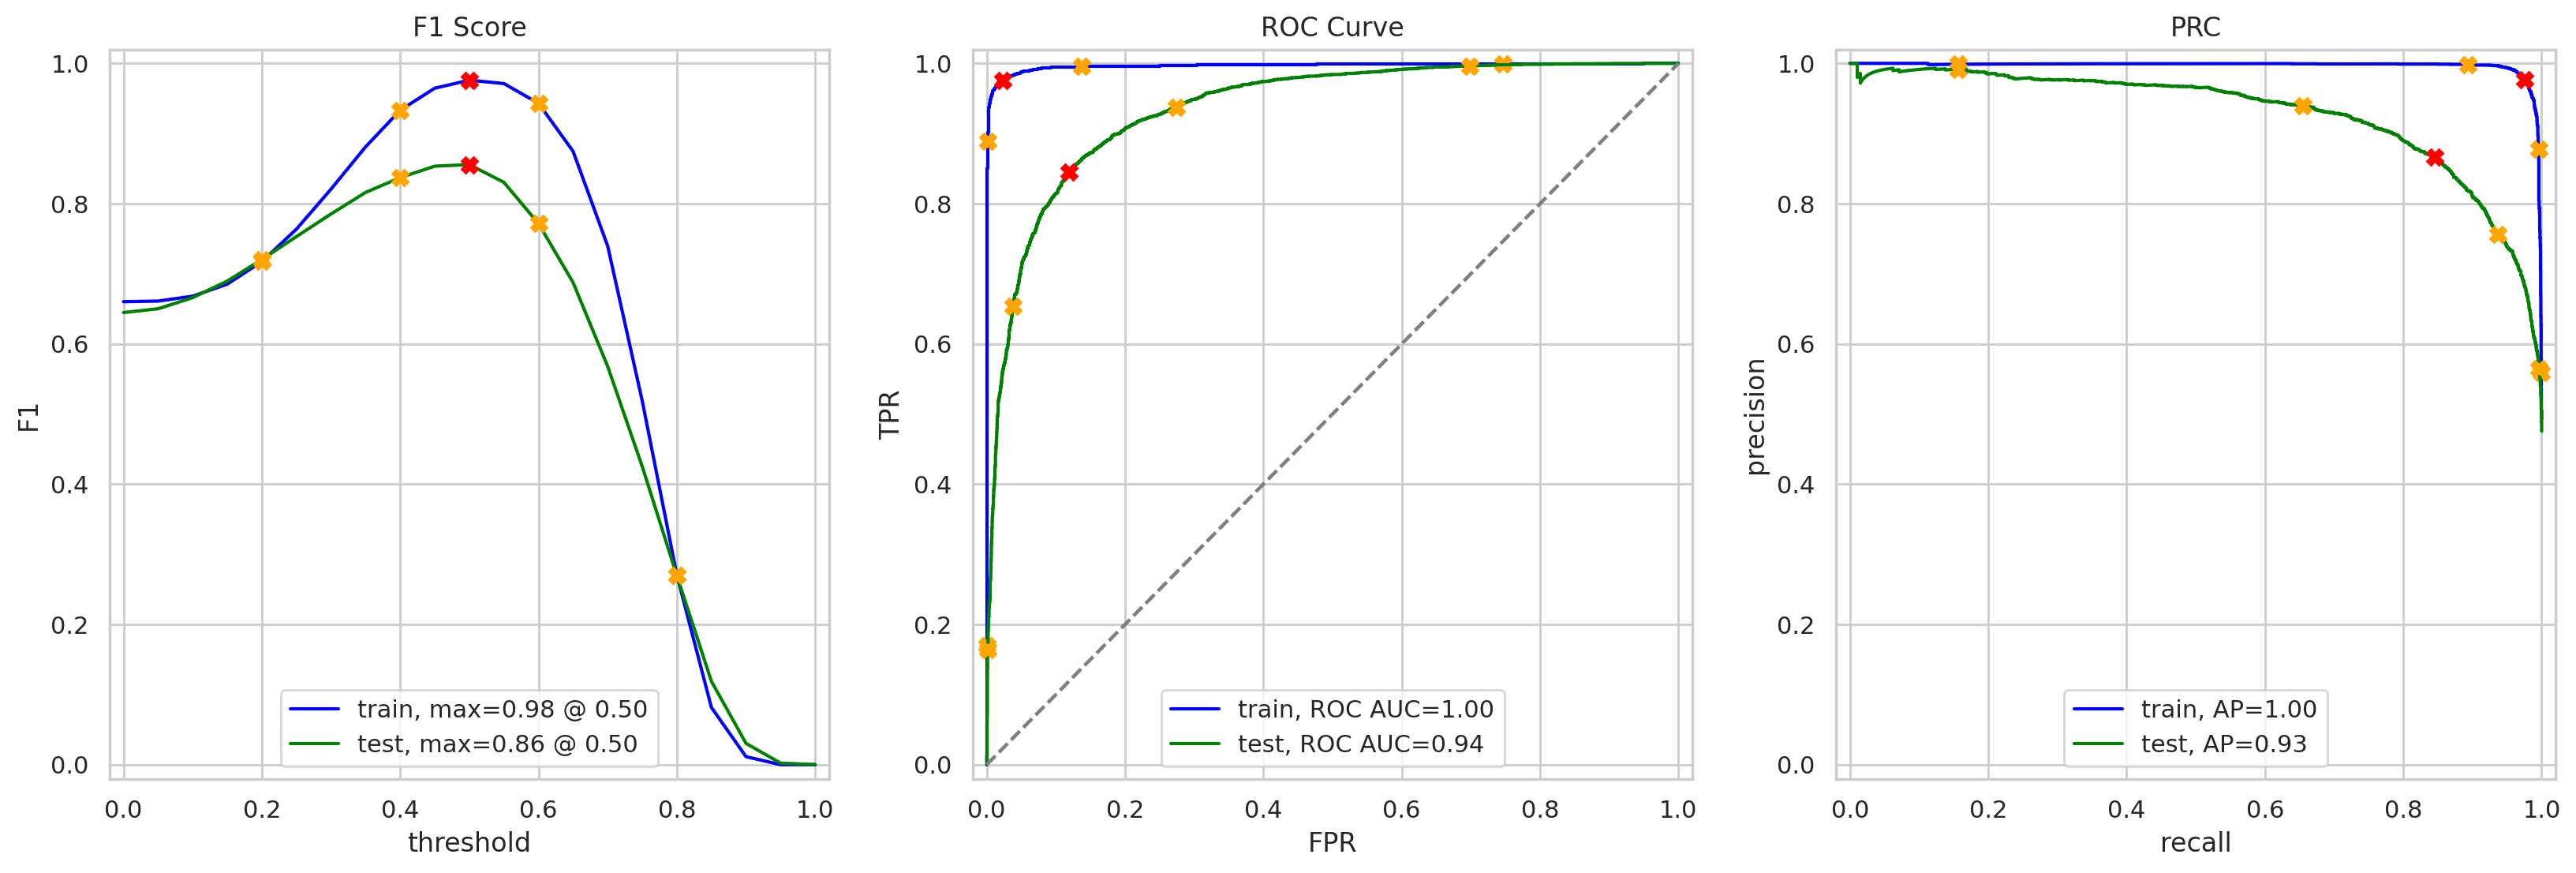

In [ ]:
evaluate_model(model_1, features_train_1, target_train, features_test_1, target_test)

In [ ]:
del features_train_1
del features_test_1

### Model 2 - spaCy, TF-IDF and LR

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [ ]:
# Apply preprocessing to the reviews
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [ ]:
# Set up TF-IDF Vectorizer with a valid min_df value
tfidfv_2 = TfidfVectorizer(min_df=1, max_features=10_000, strip_accents='unicode', lowercase=True,
                           analyzer='word', ngram_range=(1, 1), use_idf=True, smooth_idf=True,
                           sublinear_tf=True, stop_words='english')

In [ ]:
# Transform the spaCy preprocessed review text to TF-IDF vectors
features_train_spacy = tfidfv_2.fit_transform(df_reviews_train['review_spacy'].values)
features_test_spacy = tfidfv_2.transform(df_reviews_test['review_spacy'].values)

In [ ]:
# Initiate Logistic Regression
model_2 = LogisticRegression(max_iter=1000)

In [ ]:
# Train the model
model_2.fit(features_train_spacy, target_train)

LogisticRegression(max_iter=1000)

          train  test
Accuracy   0.94  0.86
F1         0.93  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


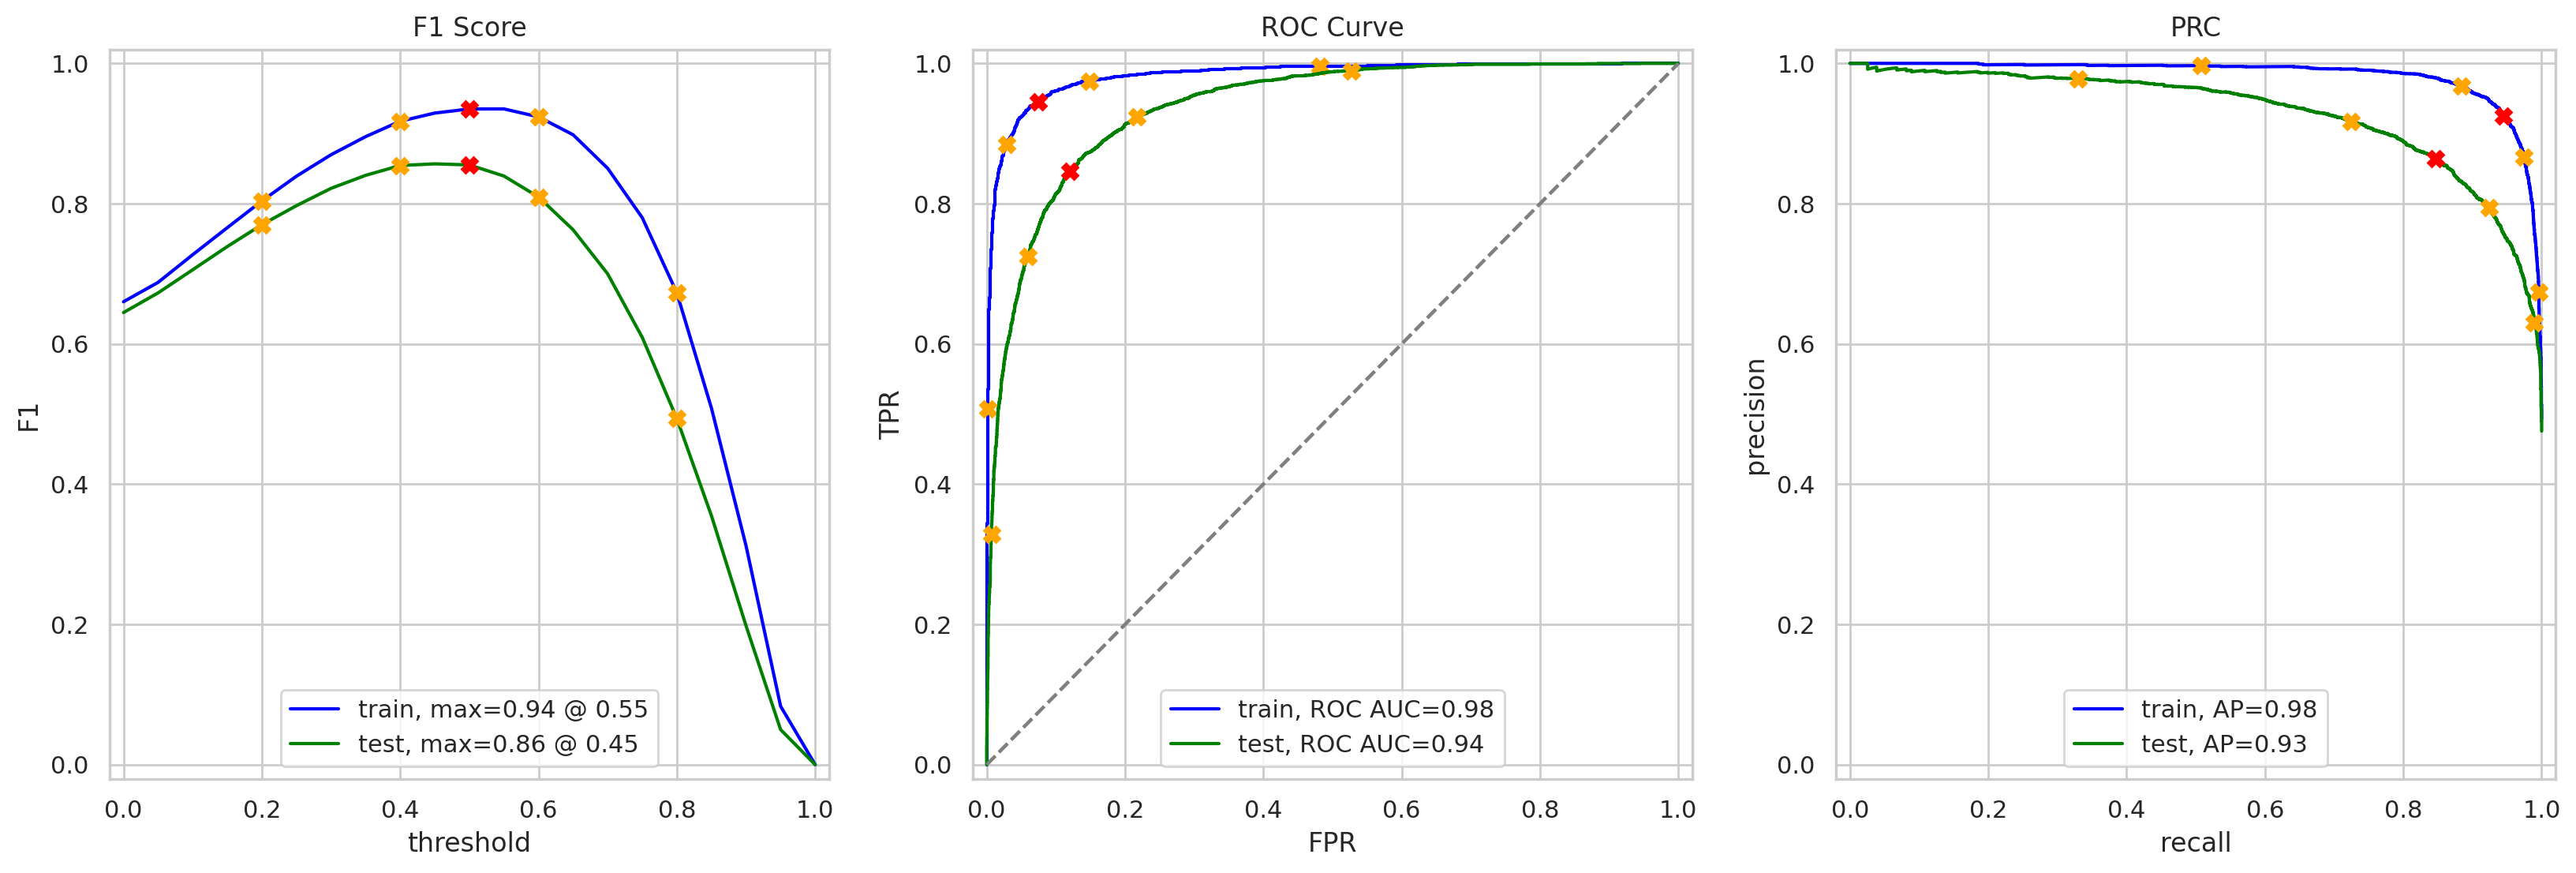

In [ ]:
# Evaluate the model
evaluate_model(model_2, features_train_spacy, target_train, features_test_spacy, target_test)

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# load spacy's small english model
# nlp already defined

In [ ]:
# initiate model
model_3 = lgb.LGBMClassifier()

In [ ]:
# train the model
model_3.fit(features_train_spacy, target_train)

[LightGBM] [Info] Number of positive: 4899, number of negative: 5045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.408192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190502
[LightGBM] [Info] Number of data points in the train set: 9944, number of used features: 4979
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492659 -> initscore=-0.029367
[LightGBM] [Info] Start training from score -0.029367


LGBMClassifier()

          train  test
Accuracy   0.95  0.84
F1         0.95  0.83
APS        0.99  0.91
ROC AUC    0.99  0.92


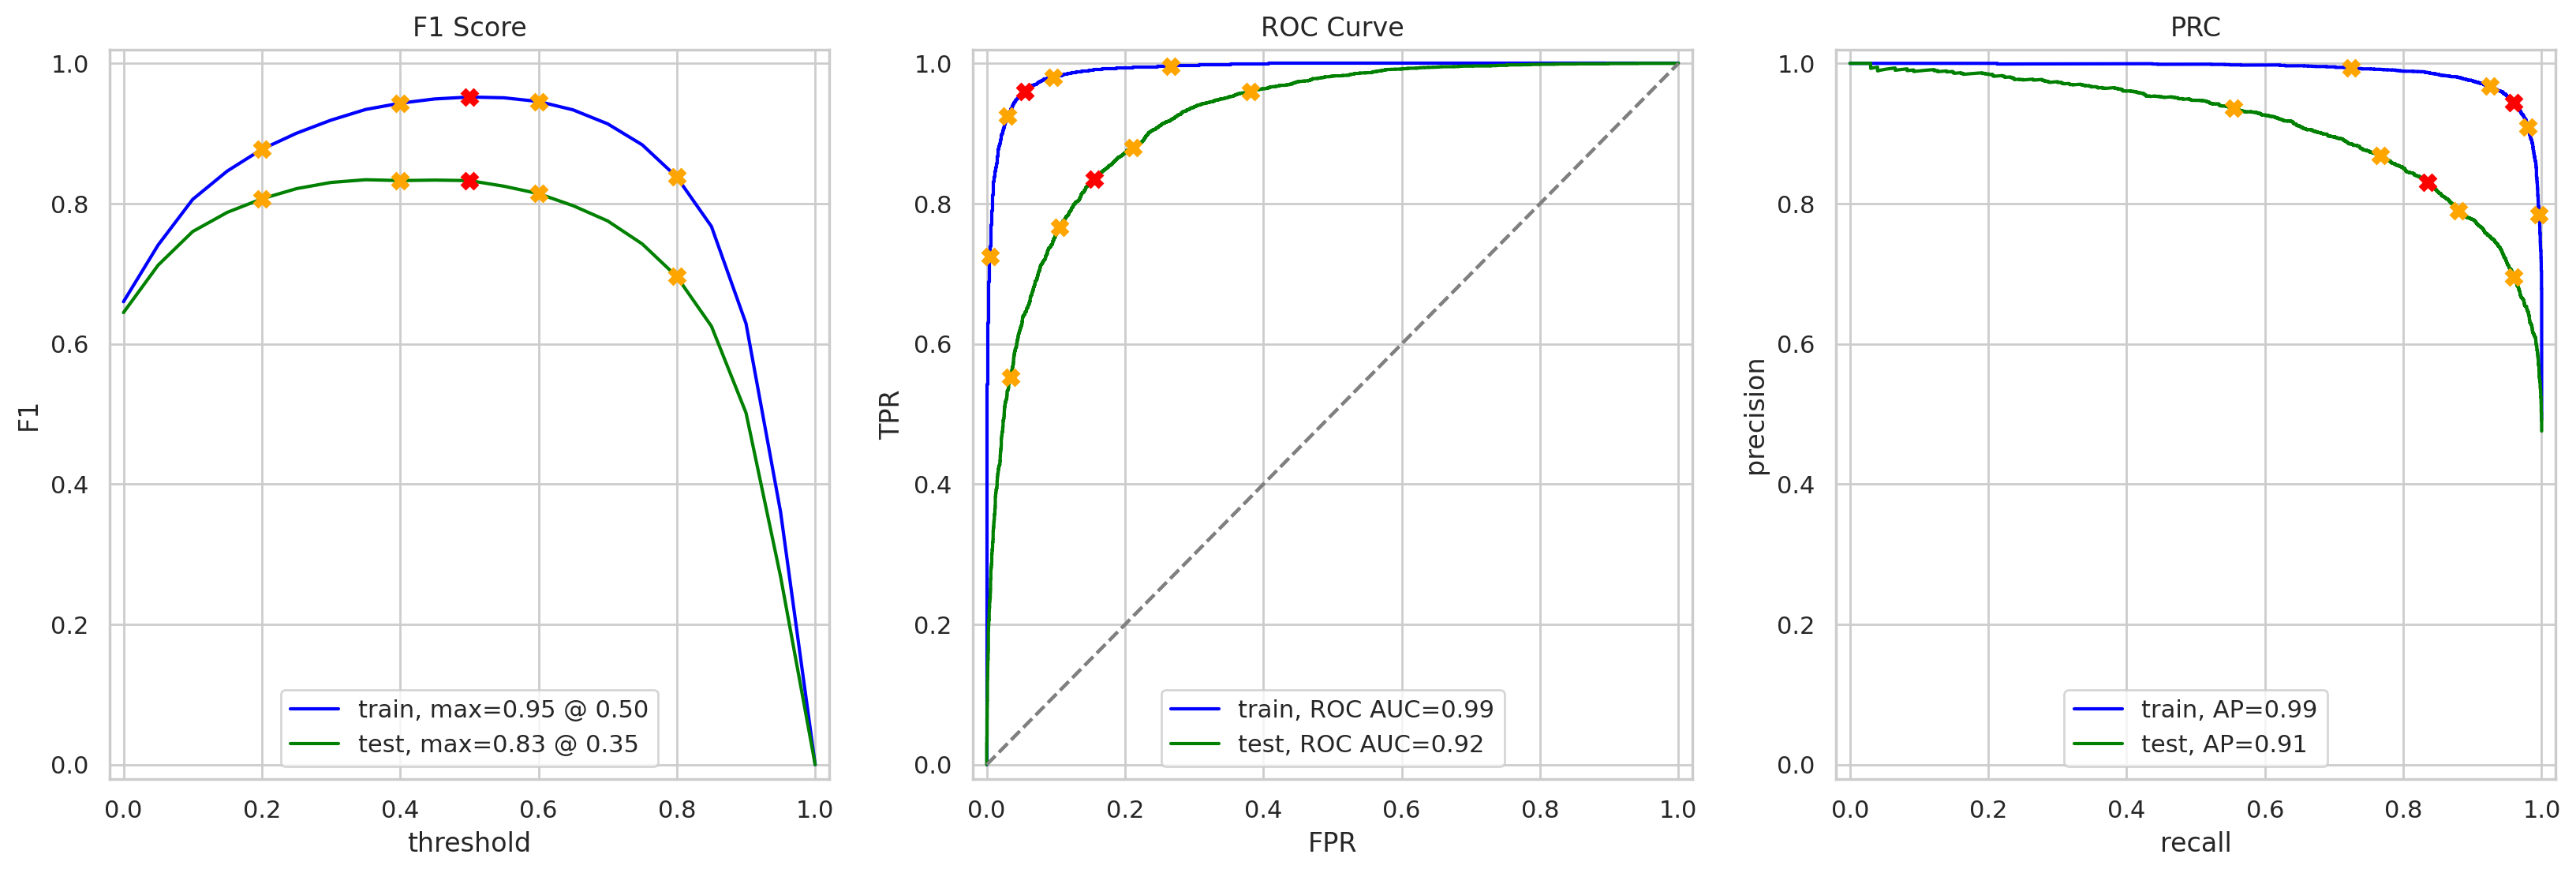

In [ ]:
# Evaluate the model
evaluate_model(model_3, features_train_spacy, target_train, features_test_spacy, target_test)

In [ ]:
# del unnecessary variables
del features_train_spacy
del features_test_spacy

###  Model 4 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
model = transformers.AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
config = transformers.AutoConfig.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=25, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids_list.append(encoding['input_ids'].flatten())
        attention_mask_list.append(encoding['attention_mask'].flatten())

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.stack(ids_list[batch_size * i: batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.stack(attention_mask_list[batch_size * i: batch_size * (i + 1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [ ]:
import torch
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [ ]:
import torch

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Check the number of available GPUs
print("Number of GPUs available:", torch.cuda.device_count())

# If GPU is available, print its name
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
Number of GPUs available: 1
GPU name: Tesla T4


In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_4 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

# on test
test_features_4 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

Using the cuda device.


  0%|          | 0/398 [00:00<?, ?it/s]

Using the cuda device.


  0%|          | 0/388 [00:00<?, ?it/s]

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_4.shape)

(9944,)
(9944, 312)


In [ ]:
#  proceed with training a model on these features
model_4 = LogisticRegression(max_iter=1000)
model_4.fit(train_features_4, target_train)

LogisticRegression(max_iter=1000)

          train  test
Accuracy   0.80  0.80
F1         0.79  0.78
APS        0.89  0.87
ROC AUC    0.89  0.88


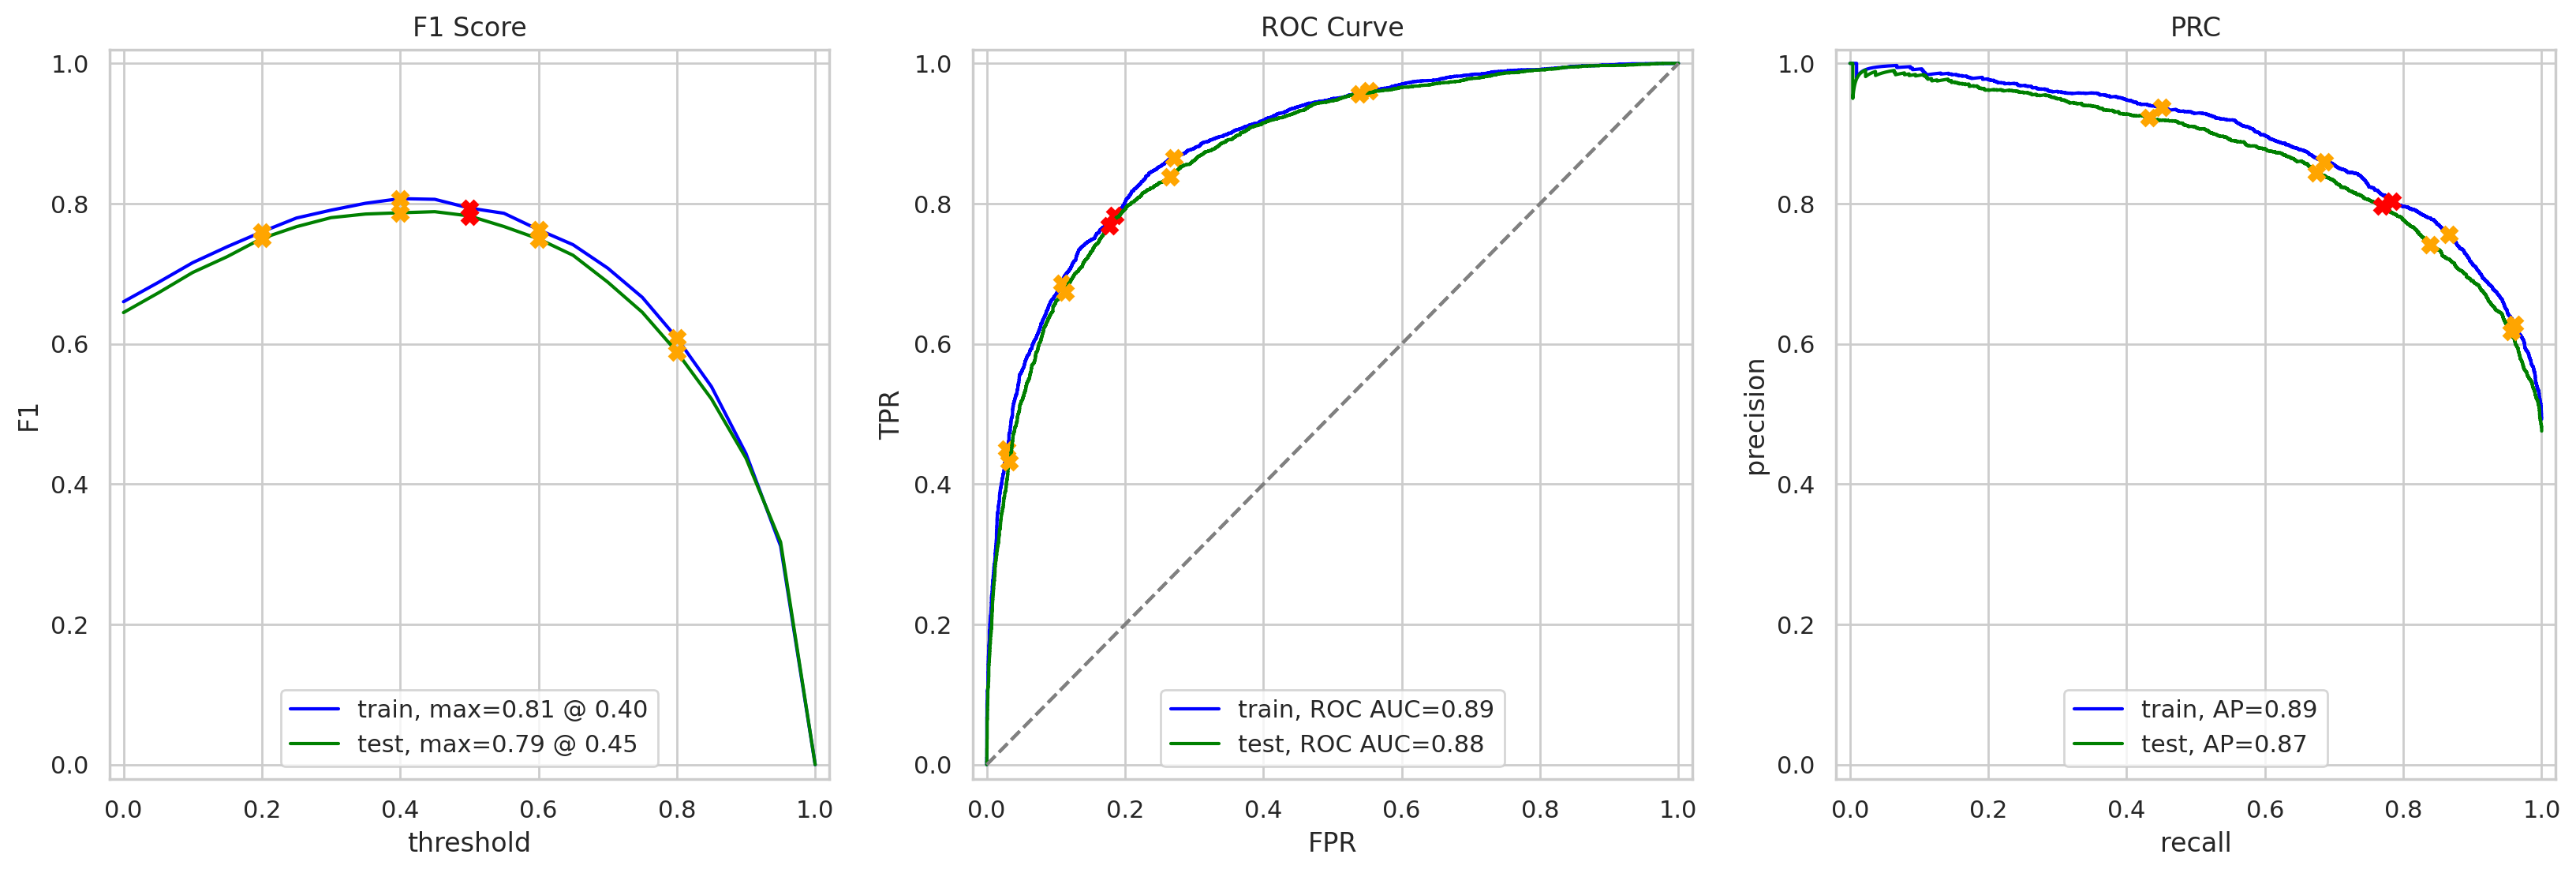

In [ ]:
# Evaluate the model
evaluate_model(model_4, train_features_4, target_train, test_features_4, target_test)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

# <put here the same normalization logic as for the main dataset>
# adding a pos column based on the reviews, 0 is negative and 1 is positive
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

my_reviews

,review,review_norm,pos
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,0
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,0
2,I was really fascinated with the movie,i was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...,1
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,1
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,0
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,1


### Model 1 NLTK, TF-IDF, LR

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:70]}')

Actual: 0 | Predicted: 0 | Text: i did not simply like it not my kind of movie
Actual: 0 | Predicted: 0 | Text: well i was bored and felt asleep in the middle of the movie
Actual: 1 | Predicted: 0 | Text: i was really fascinated with the movie
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disinterested and they got paid 
Actual: 1 | Predicted: 0 | Text: i didnt expect the reboot to be so good writers really cared about the
Actual: 1 | Predicted: 0 | Text: the movie had its upsides and downsides but i feel like overall its a 
Actual: 0 | Predicted: 0 | Text: what a rotten attempt at a comedy not a single joke lands everyone act
Actual: 1 | Predicted: 1 | Text: launching on netflix was a brave move i really appreciate being able t


### Model 2 spaCy, TF-IDF, LR

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidfv_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:70]}')

Actual: 0 | Predicted: 0 | Text: i did not simply like it not my kind of movie
Actual: 0 | Predicted: 0 | Text: well i was bored and felt asleep in the middle of the movie
Actual: 1 | Predicted: 0 | Text: i was really fascinated with the movie
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disinterested and they got paid 
Actual: 1 | Predicted: 0 | Text: i didnt expect the reboot to be so good writers really cared about the
Actual: 1 | Predicted: 0 | Text: the movie had its upsides and downsides but i feel like overall its a 
Actual: 0 | Predicted: 0 | Text: what a rotten attempt at a comedy not a single joke lands everyone act
Actual: 1 | Predicted: 1 | Text: launching on netflix was a brave move i really appreciate being able t


### Model 3 spaCy, TF-IDF, LGBMClassifer

In [ ]:
texts = my_reviews['review_norm']

tfidfv_3 = tfidfv_2
my_reviews_pred_prob = model_3.predict_proba(tfidfv_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:70]}')

Actual: 0 | Predicted: 1 | Text: i did not simply like it not my kind of movie
Actual: 0 | Predicted: 1 | Text: well i was bored and felt asleep in the middle of the movie
Actual: 1 | Predicted: 1 | Text: i was really fascinated with the movie
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disinterested and they got paid 
Actual: 1 | Predicted: 1 | Text: i didnt expect the reboot to be so good writers really cared about the
Actual: 1 | Predicted: 0 | Text: the movie had its upsides and downsides but i feel like overall its a 
Actual: 0 | Predicted: 0 | Text: what a rotten attempt at a comedy not a single joke lands everyone act
Actual: 1 | Predicted: 1 | Text: launching on netflix was a brave move i really appreciate being able t


### Model 4 BERT

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_4 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_4)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:70]}')

Actual: 0 | Predicted: 0 | Text: i did not simply like it not my kind of movie
Actual: 0 | Predicted: 0 | Text: well i was bored and felt asleep in the middle of the movie
Actual: 1 | Predicted: 1 | Text: i was really fascinated with the movie
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disinterested and they got paid 
Actual: 1 | Predicted: 0 | Text: i didnt expect the reboot to be so good writers really cared about the
Actual: 1 | Predicted: 1 | Text: the movie had its upsides and downsides but i feel like overall its a 
Actual: 0 | Predicted: 0 | Text: what a rotten attempt at a comedy not a single joke lands everyone act
Actual: 1 | Predicted: 1 | Text: launching on netflix was a brave move i really appreciate being able t


## Conclusions

The aim of this project is to develop a robust model for sentiment analysis of movie reviews. The project involves training various machine learning models to predict the sentiment (positive or negative) of movie reviews, with a focus on prediction quality, accuracy, and reliability.

### Training Performance:
Model 1: NLTK, TF-IDF, LR

- Accuracy: 0.94 (train), 0.86 (test)
- F1 Score: 0.93 (train), 0.86 (test)
- APS (Average Precision Score): 0.98 (train), 0.93 (test)
- ROC AUC: 0.98 (train), 0.94 (test)

Observation: Model 1 performs well on both training and test sets, indicating strong predictive power but with a slight overfitting tendency.

Model 2:spaCy, TF-IDF, LR

- Accuracy: 0.94 (train), 0.86 (test)
- F1 Score: 0.93 (train), 0.86 (test)
- APS: 0.98 (train), 0.93 (test)
- ROC AUC: 0.98 (train), 0.94 (test)

Observation: Model 2 shows identical performance to Model 1, suggesting a similar level of predictive strength and reliability.

Model 3: spaCy, TF-IDF, LGBMClassifer
- Accuracy: 0.95 (train), 0.84 (test)
- F1 Score: 0.95 (train), 0.83 (test)
- APS: 0.99 (train), 0.91 (test)
- ROC AUC: 0.99 (train), 0.92 (test)

Observation: Model 3 demonstrates higher performance on the training set but lower performance on the test set, indicating overfitting and reduced generalization compared to Models 1 and 2.

Model 4: BERT
- Accuracy: 0.80 (train), 0.80 (test)
- F1 Score: 0.79 (train), 0.78 (test)
- APS: 0.89 (train), 0.87 (test)
- ROC AUC: 0.89 (train), 0.88 (test)

Observation: Model 4 has lower overall metrics compared to the other models, suggesting less predictive power and robustness but with consistent performance between training and test sets.

### Performance on Personal Reviews:

Model 1: NLTK, TF-IDF, LR

Correctly identifies negative reviews but misclassifies all positive reviews as negative.
Tends to be overly conservative in predicting positive sentiment.

Model 2: spaCy, TF-IDF, LR

Identical performance to Model 1, correctly identifying negative reviews but failing to accurately classify positive ones.
Shares the same conservative bias in predicting positive sentiment.

Model 3: spaCy, TF-IDF, LGBMClassifer

Struggles with distinguishing sentiment, incorrectly labeling some negative reviews as positive.
Shows inconsistency, particularly in correctly identifying negative sentiment, but does better with positive reviews.

Model 4: BERT

Correctly identifies both negative and positive reviews, though with some misclassification of a positive review as negative.
Offers a balanced approach but with occasional errors in predicting positive sentiment.

Overall Conclusion:

- Model 1 and Model 2 demonstrate strong performance on training data, but their conservative bias leads to misclassification of positive reviews on personal data.
- Model 3 shows a higher tendency towards overfitting, leading to inconsistent predictions on personal reviews, particularly struggling with negative sentiment.
- Model 4, while having lower overall metrics, provides a more balanced performance on personal reviews, though it still occasionally misclassifies positive sentiment. Its consistent performance across training and test sets makes it a more reliable option for sentiment analysis despite its lower accuracy and F1 scores.